# Wine exploration and clustering

# Data exploration

Libraries import

In [33]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from warnings import filterwarnings # This filter was run after the finished notebook to avoid filtering important warnings
# filterwarnings('ignore')

# Data exploration libraries
from requests import get
from io import StringIO
from ydata_profiling import ProfileReport
from IPython.display import HTML
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# ML libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

In [34]:
url = 'https://storage.googleapis.com/the_public_bucket/wine-clustering.csv' # Direct link to the dataset
response = get(url)

if response.status_code == 200:
    data = pd.read_csv(StringIO(response.text)) # Dataframe from the csv url
    print('Data retrieved successfully')
else:
    print(f'Failed to download dataset. Status code: {response.status_code}')

data.head(2)
print(f'Dataframe dimensions: {data.shape}')

Data retrieved successfully
Dataframe dimensions: (178, 13)


## Statistical analysis

In [36]:
print(f'Total of null data: {data.isnull().sum().sum()}')
print(f'Total of duplicated data: {data.duplicated().sum()}')

inf_values = np.isinf(data)
inf_rows, inf_cols = np.where(inf_values)

print(f'Rows with inf values: {inf_rows.sum()}')
print(f'Columns with inf values: {inf_cols.sum()}')

Total of null data: 0
Total of duplicated data: 0
Rows with inf values: 0
Columns with inf values: 0


In [37]:
# profile_report = ProfileReport(data, title='Wine Clustering Profiling Report', explorative=True)
# profile_report.to_file('../reports/wine_clustering_profiling_report.html')
# profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
print(f'Data information: \n{data.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB
Data information: 
None


In [39]:
print(f'Data description: \n{data.describe()}')

Data description: 
          Alcohol  Malic_Acid         Ash  Ash_Alcanity   Magnesium  \
count  178.000000  178.000000  178.000000    178.000000  178.000000   
mean    13.000618    2.336348    2.366517     19.494944   99.741573   
std      0.811827    1.117146    0.274344      3.339564   14.282484   
min     11.030000    0.740000    1.360000     10.600000   70.000000   
25%     12.362500    1.602500    2.210000     17.200000   88.000000   
50%     13.050000    1.865000    2.360000     19.500000   98.000000   
75%     13.677500    3.082500    2.557500     21.500000  107.000000   
max     14.830000    5.800000    3.230000     30.000000  162.000000   

       Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000         

In [40]:
# Full distribution analysis
mean, std, skewness, kurtosis = [], [], [], []

for column in data.columns:
    mean.append(data[column].mean())
    std.append(data[column].std())
    skewness.append(stats.skew(data[column]))
    kurtosis.append(stats.kurtosis(data[column]))

stats_df = pd.DataFrame({'Column': data.columns, 
                         'Mean': mean,
                         'Std': std,
                         'Skewness': skewness, 
                         'Kurtosis': kurtosis})
stats_df

Column        Mean         Std  Skewness  Kurtosis
0                Alcohol   13.000618    0.811827 -0.051047 -0.862260
1             Malic_Acid    2.336348    1.117146  1.030869  0.257348
2                    Ash    2.366517    0.274344 -0.175207  1.078576
3           Ash_Alcanity   19.494944    3.339564  0.211247  0.440823
4              Magnesium   99.741573   14.282484  1.088915  2.012806
5          Total_Phenols    2.295112    0.625851  0.085907 -0.845857
6             Flavanoids    2.029270    0.998859  0.025129 -0.889365
7   Nonflavanoid_Phenols    0.361854    0.124453  0.446349 -0.652952
8        Proanthocyanins    1.590899    0.572359  0.512769  0.505671
9        Color_Intensity    5.058090    2.318286  0.861248  0.337370
10                   Hue    0.957449    0.228572  0.020913 -0.368025
11                 OD280    2.611685    0.709990 -0.304690 -1.089675
12               Proline  746.893258  314.907474  0.761336 -0.275000

In [41]:
# Interquartile Range (IQR) method to remove outliers
Q1, Q3 = data.quantile(0.25), data.quantile(0.75) # First and third quartiles
IQR = Q3 - Q1
data_transformed = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Number of rows deleted
rows_deleted = len(data) - len(data_transformed)
print(f'Number of rows deleted: {rows_deleted}')
print(f'Percentage of rows deleted: {rows_deleted / len(data) * 100:.1f}%')

Number of rows deleted: 17
Percentage of rows deleted: 9.6%


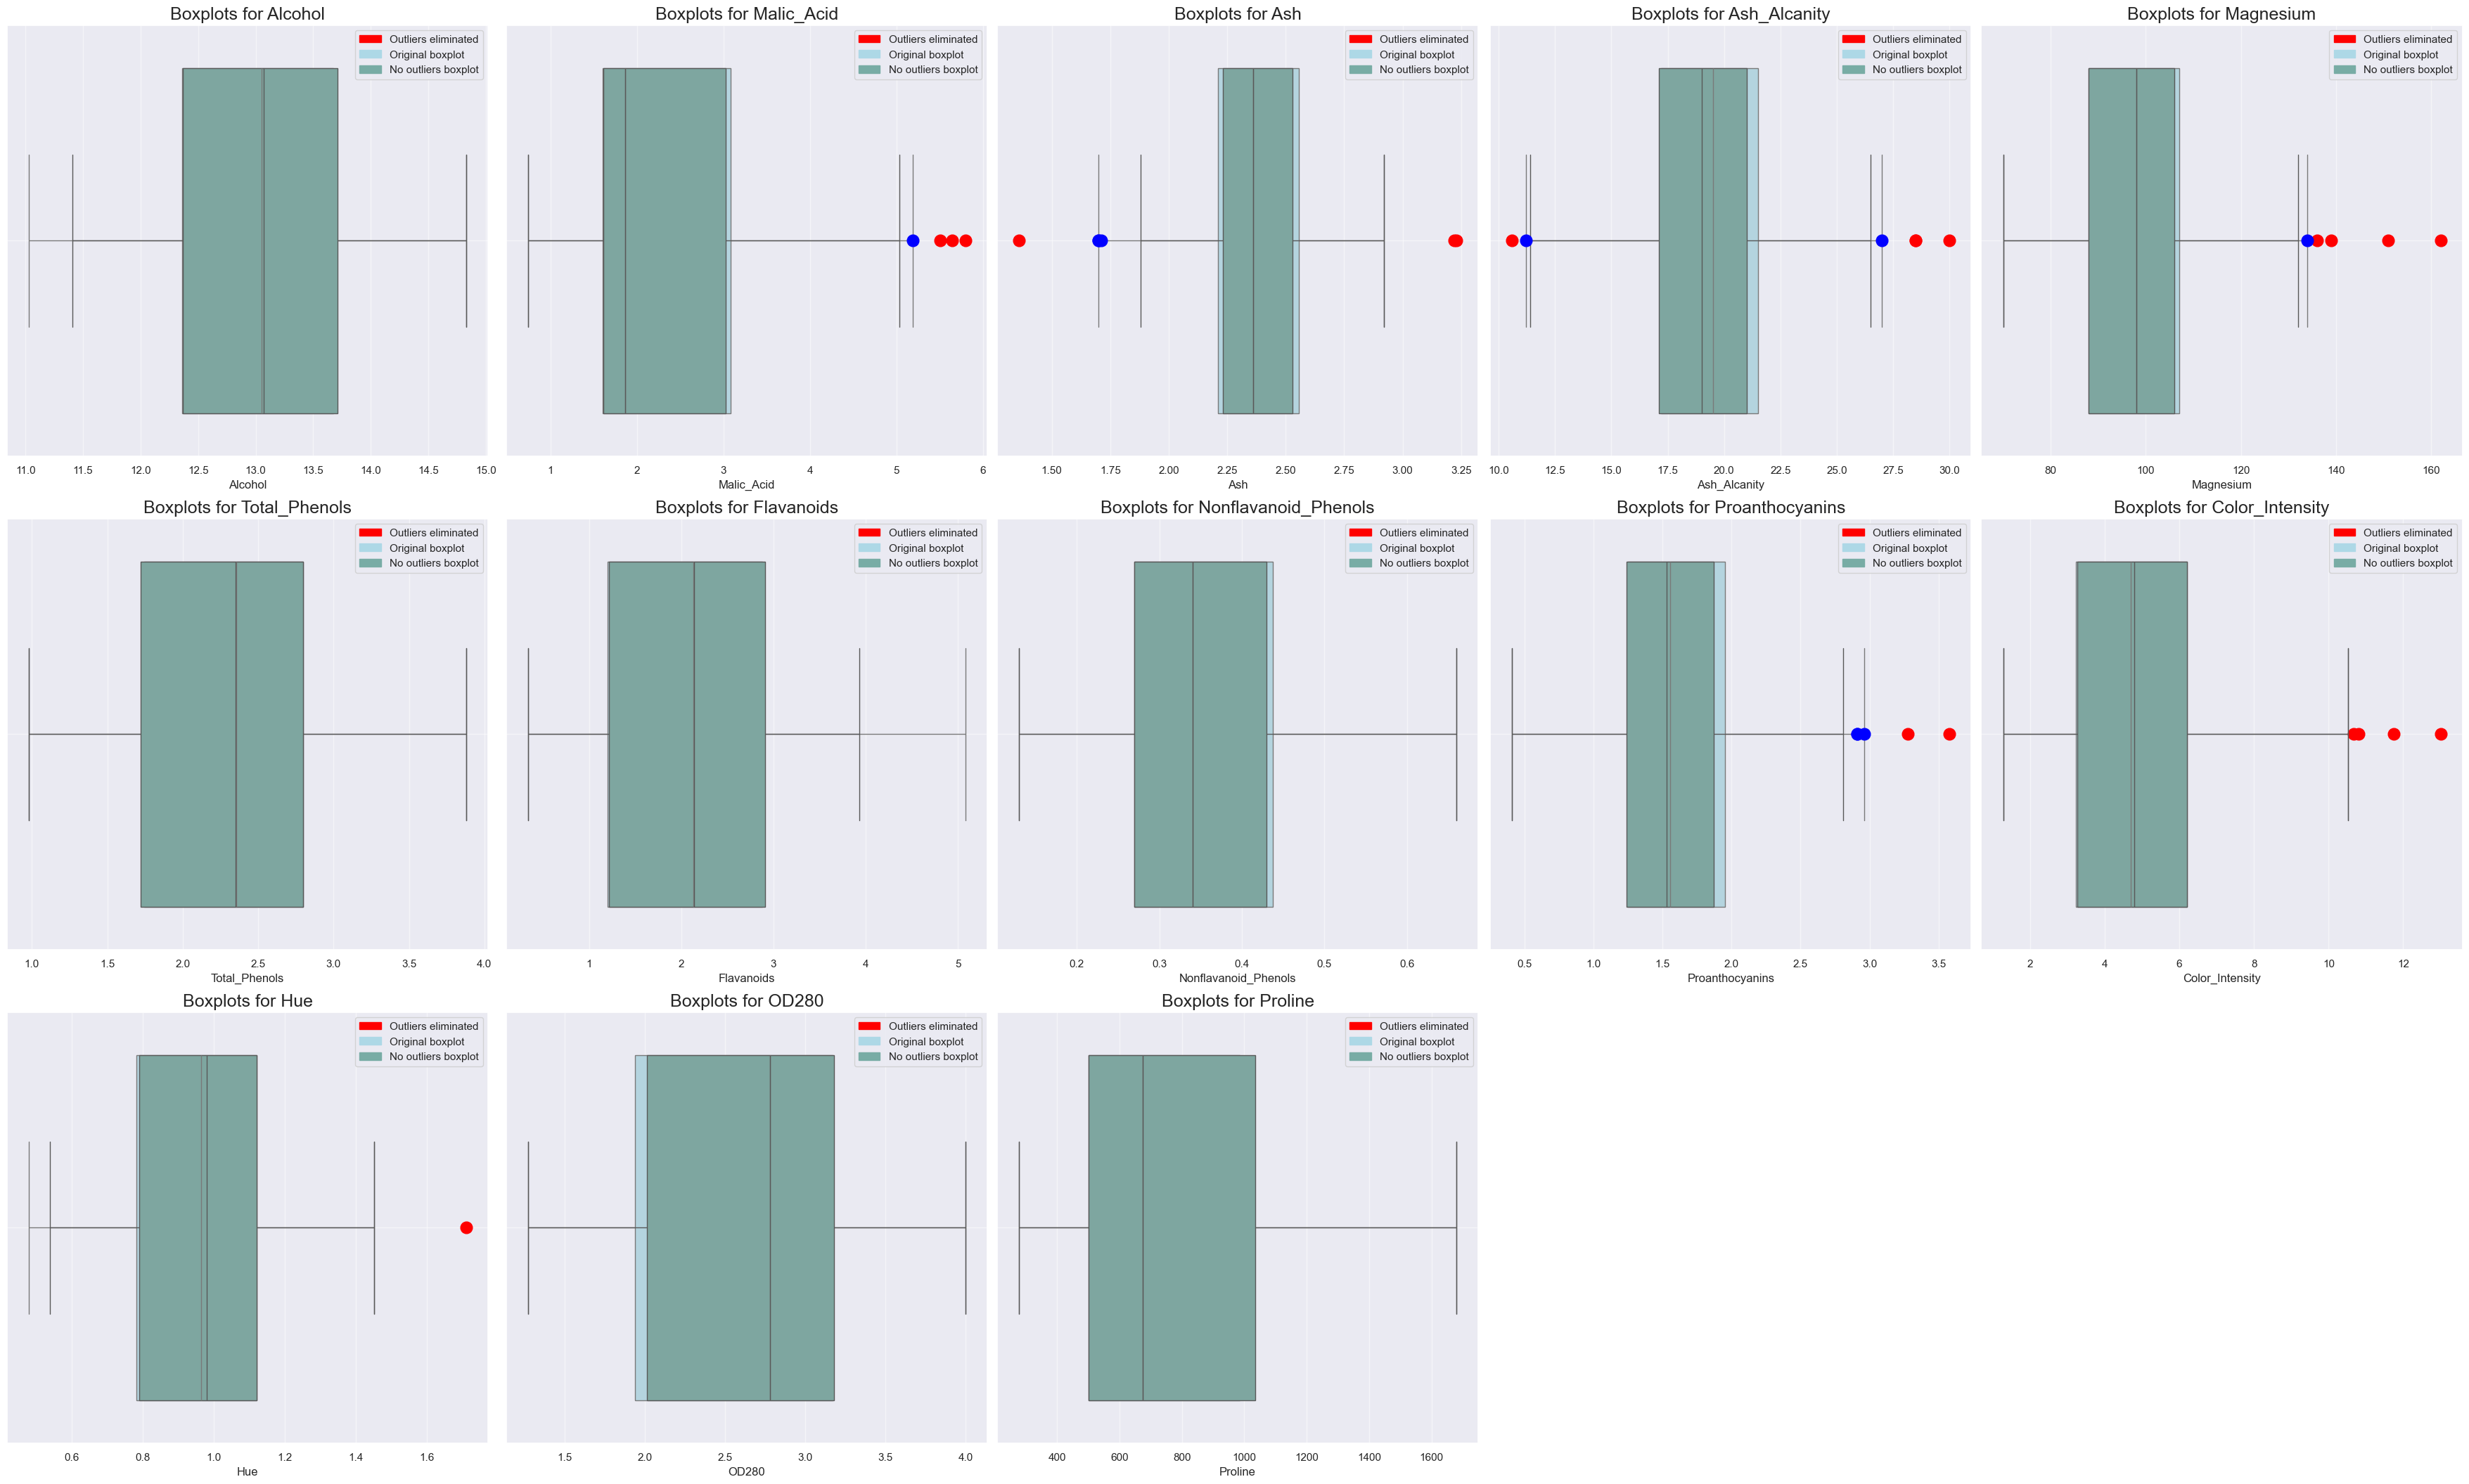

In [70]:
import matplotlib.patches as mpatches
sns.set_style('dark')

num_plots = len(data.columns)
total_cols = 5
total_rows = num_plots // total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)

flierprops_orig = dict(marker='o', markerfacecolor='red', markersize=12,
                       linestyle='none', markeredgecolor='red')
flierprops_transformed = dict(marker='o', markerfacecolor='blue', markersize=12,
                              linestyle='none', markeredgecolor='blue')

for i, var in enumerate(data.columns):
    row = i // total_cols
    pos = i % total_cols
    plot = sns.boxplot(x=var, data=data, ax=axs[row][pos], flierprops=flierprops_orig, color='lightblue', legend=True)
    plot = sns.boxplot(x=var, data=data_transformed, ax=axs[row][pos], flierprops=flierprops_transformed, color='#78ACA5')
    plot.set_title(f'Boxplots for {var}', fontdict={'fontsize': 18})
    plot.grid(alpha=0.5)

    # Add legend
    red_patch = mpatches.Patch(color='red', label='Outliers eliminated')
    lightblue_patch = mpatches.Patch(color='lightblue', label='Original boxplot')
    otherblue_patch = mpatches.Patch(color='#78ACA5', label='No outliers boxplot')
    plot.legend(handles=[red_patch, lightblue_patch, otherblue_patch])

# Remove empty subplots
if num_plots % total_cols:
    for ax in axs.flatten()[num_plots:]:
        ax.remove()

plt.show()